# Data Mining Project - Group XX 2025/2026

# Import Libraries

In [46]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from itertools import product
from ydata_profiling import ProfileReport

# for better resolution plots
%config InlineBackend.figure_format = 'retina'

#o svg consegue ampliar infinitamente os gráficos sem perder qualidade mas às vezes é mais lento 
#por isso agora usamos retina


sns.set()

# Loading the Data

Import the datasets from csv files using commas as separators of the columns and setting the unique customer identifier as the index of both columns.

In [47]:
flightsDB = pd.read_csv('DM_AIAI_FlightsDB.csv', sep = ",", index_col= "Loyalty#")
customerDB = pd.read_csv('DM_AIAI_CustomerDB.csv', sep = ",", index_col= "Loyalty#")
metaData = pd.read_csv('DM_AIAI_Metadata.csv', sep = ";", header= None)

Remove the 'Unnamed' column referring to a sequential numbering of the rows, as we set the column "Loyalty#" as the index

In [48]:
customerDB = customerDB.iloc[:, 1:]
customerDB

,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
Loyalty#,,,,,,,,,,,,,,,,,,,
480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,female,Bachelor,Urban,70146.0,Married,Star,2/15/2019,NaN,3839.14,Standard
549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,male,College,Rural,0.0,Divorced,Star,3/9/2019,NaN,3839.61,Standard
429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,male,College,Urban,0.0,Single,Star,7/14/2017,1/8/2021,3839.75,Standard
608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,P1W 1K4,male,College,Suburban,0.0,Single,Star,2/17/2016,NaN,3839.75,Standard
530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,J8Y 3Z5,male,Bachelor,Suburban,97832.0,Married,Star,10/25/2017,NaN,3842.79,2021 Promotion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100012,Ethan,Thompson,Ethan Thompson,Canada,Quebec,Quebec City,46.759733,-71.141009,Y0C 7D6,male,Bachelor,Suburban,NaN,Single,Star,2/27/2019,2/27/2019,NaN,Standard
100013,Layla,Young,Layla Young,Canada,Alberta,Edmonton,53.524829,-113.546357,L3S 9Y3,female,Bachelor,Rural,NaN,Married,Star,9/20/2017,9/20/2017,NaN,Standard
100014,Amelia,Bennett,Amelia Bennett,Canada,New Brunswick,Moncton,46.051866,-64.825428,G2S 2B6,male,Bachelor,Rural,NaN,Married,Star,11/28/2020,11/28/2020,NaN,Standard


# Metadata

**FlightsDB Database Variable Description**
- **Loyalty#:**	Unique customer identifier linking to CustomerDB
- **Year:**	Year of flight activity record
- **Month:**	Month of flight activity record (1-12)
- **YearMonthDate:**	First day of the month for the activity period
- **NumFlights:**	Total number of flights taken by customer in the month
- **NumFlightsWithCompanions:**	Number of flights where customer traveled with companions
- **DistanceKM:**	Total distance traveled in kilometers for the month
- **PointsAccumulated:**	Loyalty points earned by customer during the month
- **PointsRedeemed:**	Loyalty points spent/redeemed by customer during the month
- **DollarCostPointsRedeemed:**	Dollar value of points redeemed during the month

**CustomerDB Database Variable Description**
- **Loyalty#:**  Unique customer identifier for loyalty program members
- **First Name:**   Customer's first name
- **Last Name:**   Customer's last name 
- **Customer Name:** Customer's full name (concatenated)
- **Country:**	Customer's country of residence
- **Province or State:**	Customer's province or state
- **City:**	Customer's city of residence
- **Latitude:**	Geographic latitude coordinate of customer location
- **Longitude:**	Geographic longitude coordinate of customer locatio
- **Postal code:**	Customer's postal/ZIP code
- **Gender:**	Customer's gender
- **Education:**	Customer's highest education level (Bachelor, College, etc.)
- **Location:** Code	Urban/Suburban/Rural classification of customer residence
- **Income:**	Customer's annual income
- **Marital Status:**	Customer's marital status (Married, Single, Divorced)
- **LoyaltyStatus:**	Current tier status in loyalty program (Star > Nova > Aurora)
- **EnrollmentDateOpening:**	Date when customer joined the loyalty program
- **CancellationDate:**	Date when customer left the program
- **Customer Lifetime:** Value	Total calculated monetary value of customer relationship
- **EnrollmentType:**	Method of joining loyalty program

# Business Understanding

Define the project's objectives and requirements by translating business goals into data science goals. 
This involves understanding the business problem, identifying success criteria, determining resource needs, and creating an initial project plan with stages, duration, and costs.

Business Success criteria: 
- “A 5% reduction in churn results in €50k monthly savings.”

Data mining Success criteria: 
- “Model accuracy ≥ 85% on test data.” 
- “Segments must be interpretable and actionable by marketing.”


# Data Understanding

On this section we will inspect the data shape, column names and data types for each dataset

## General Look at the DataSet (FlightsDB)

In [49]:
flightsDB.shape

(608436, 9)

In [50]:
flightsDB.head(15)


,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed
Loyalty#,,,,,,,,,
413052,2021,12,12/1/2021,2.0,2.0,9384.0,938.0,0.0,0.0
464105,2021,12,12/1/2021,0.0,0.0,0.0,0.0,0.0,0.0
681785,2021,12,12/1/2021,10.0,3.0,14745.0,1474.0,0.0,0.0
185013,2021,12,12/1/2021,16.0,4.0,26311.0,2631.0,3213.0,32.0
216596,2021,12,12/1/2021,9.0,0.0,19275.0,1927.0,0.0,0.0
486956,2021,12,12/1/2021,12.0,7.0,23967.0,2396.0,0.0,0.0
247514,2021,12,12/1/2021,17.0,7.0,23029.0,2302.0,0.0,0.0
711864,2021,12,12/1/2021,6.0,0.0,25995.0,2599.0,0.0,0.0
721372,2021,12,12/1/2021,11.0,3.0,30758.0,3075.0,0.0,0.0


In [51]:
flightsDB.tail(15)

,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed
Loyalty#,,,,,,,,,
999498,2019,12,12/1/2019,0.9,0.9,30283.2,3028.32,0.0,0.0
999513,2019,12,12/1/2019,0.0,0.0,0.0,0.00,0.0,0.0
999524,2019,12,12/1/2019,13.5,4.5,22572.9,2257.29,0.0,0.0
999550,2019,12,12/1/2019,8.1,0.0,18168.3,1816.83,0.0,0.0
999589,2019,12,12/1/2019,0.0,0.0,0.0,0.00,0.0,0.0
999631,2019,12,12/1/2019,3.6,1.8,12262.5,1226.25,0.0,0.0
999731,2019,12,12/1/2019,0.0,0.0,0.0,0.00,0.0,0.0
999758,2019,12,12/1/2019,0.0,0.0,0.0,0.00,0.0,0.0
999788,2019,12,12/1/2019,0.0,0.0,0.0,0.00,0.0,0.0


From the visualization of the head and tail of the data base we can already understand that some errors exist:

    - NumFlights and NumFlightsWithCompanions as floats...
    - PointsAccumulated and PointsRedeemed as floats. Should they be integers?
We will further analyse this using describe and info.


In [52]:
flightsDB.info()

<class 'pandas.core.frame.DataFrame'>
Index: 608436 entries, 413052 to 999986
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Year                      608436 non-null  int64  
 1   Month                     608436 non-null  int64  
 2   YearMonthDate             608436 non-null  object 
 3   NumFlights                608436 non-null  float64
 4   NumFlightsWithCompanions  608436 non-null  float64
 5   DistanceKM                608436 non-null  float64
 6   PointsAccumulated         608436 non-null  float64
 7   PointsRedeemed            608436 non-null  float64
 8   DollarCostPointsRedeemed  608436 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 46.4+ MB


From info we can see that:

    - NumFlights and NumFlightsWithCompanions as floats...
    - PointsAccumulated and PointsRedeemed as floats. Should they be integers? 
    - There aren't missing values

What will we do?

    Analyse with describe to have a different view

In [53]:
#To confirm that missing values don't exist
flightsDB.replace("", np.nan, inplace=True)
flightsDB.isna().sum()

Year                        0
Month                       0
YearMonthDate               0
NumFlights                  0
NumFlightsWithCompanions    0
DistanceKM                  0
PointsAccumulated           0
PointsRedeemed              0
DollarCostPointsRedeemed    0
dtype: int64

In [54]:
flightsDB.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,608436.0,2020.000000,0.816497,2019.0,2019.00,2020.000,2021.0000,2021.0
Month,608436.0,6.500000,3.452055,1.0,3.75,6.500,9.2500,12.0
NumFlights,608436.0,3.908107,5.057889,0.0,0.00,0.000,7.2000,21.0
NumFlightsWithCompanions,608436.0,0.983944,2.003785,0.0,0.00,0.000,0.9000,11.0
DistanceKM,608436.0,7939.341419,10260.421873,0.0,0.00,856.400,15338.1750,42040.0
PointsAccumulated,608436.0,793.777781,1025.918521,0.0,0.00,85.275,1533.7125,4204.0
PointsRedeemed,608436.0,235.251678,983.233374,0.0,0.00,0.000,0.0000,7496.0
DollarCostPointsRedeemed,608436.0,2.324835,9.725168,0.0,0.00,0.000,0.0000,74.0


In [55]:
flightsDB.describe(include='object')

#o "top" é a moda e "freq" é a frequencia do valor mais frequente
#"unique" é a quantidade de valores unicos ((36 datas diferentes pq é o primeiro dia de cada mês durante 3 anos))
#"count" é o numero de valores nao nulos

,YearMonthDate
count,608436
unique,36
top,12/1/2021
freq,16901


From both numeric and categorical describe we don't notice any weird value.

## Data Exploration and Analysis (FlightDB)

### Unique, Max, Min 

In [56]:
print(flightsDB["Year"].unique())
print(flightsDB["Month"].unique())

[2021 2020 2019]
[12  6  5  4  3  2  1 11 10  9  8  7]


From the code above we can see that our dataset have only values from the years of 2019, 2020 and 2021 and have values from all months of the year.

In [57]:
print(f"The minimum value of 'NumFlights' is: {flightsDB["NumFlights"].min()}")
print(f"The maximum value of 'InNumFlightscome' is: {flightsDB["NumFlights"].max()}")

print(f"\nThe minimum value of 'NumFlightsWithCompanions' is: {flightsDB["NumFlightsWithCompanions"].min()}")
print(f"The maximum value of 'NumFlightsWithCompanions' is: {flightsDB["NumFlightsWithCompanions"].max()}")

print(f"\nThe minimum value of 'DistanceKM' is: {flightsDB["DistanceKM"].min()}")
print(f"The maximum value of 'DistanceKM' is: {flightsDB["DistanceKM"].max()}")

print(f"\nThe minimum value of 'PointsAccumulated' is: {flightsDB["PointsAccumulated"].min()}")
print(f"The maximum value of 'PointsAccumulated' is: {flightsDB["PointsAccumulated"].max()}")

print(f"\nThe minimum value of 'PointsRedeemed' is: {flightsDB["PointsRedeemed"].min()}")
print(f"The maximum value of 'PointsRedeemed' is: {flightsDB["PointsRedeemed"].max()}")

print(f"\nThe minimum value of 'DollarCostPointsRedeemed' is: {flightsDB["DollarCostPointsRedeemed"].min()}")
print(f"The maximum value of 'DollarCostPointsRedeemed' is: {flightsDB["DollarCostPointsRedeemed"].max()}")

The minimum value of 'NumFlights' is: 0.0
The maximum value of 'InNumFlightscome' is: 21.0

The minimum value of 'NumFlightsWithCompanions' is: 0.0
The maximum value of 'NumFlightsWithCompanions' is: 11.0

The minimum value of 'DistanceKM' is: 0.0
The maximum value of 'DistanceKM' is: 42040.0

The minimum value of 'PointsAccumulated' is: 0.0
The maximum value of 'PointsAccumulated' is: 4204.0

The minimum value of 'PointsRedeemed' is: 0.0
The maximum value of 'PointsRedeemed' is: 7496.0

The minimum value of 'DollarCostPointsRedeemed' is: 0.0
The maximum value of 'DollarCostPointsRedeemed' is: 74.0


From this we can see that there are some customers with 0 flights in a month and the maximum number of flights is 21 in a month

### Values Count

In [58]:
flightsDB["NumFlights"].value_counts()
#it looks like the most common number of flights in a month is 0, meaning that many customers don't fly every month

NumFlights
0.0     304524
9.0      20344
3.0      18228
11.0     15705
5.0      15084
7.0      14561
8.0      14357
6.0      13847
2.0      13641
10.0     13363
4.0      12821
1.0      12667
13.0     10782
12.0     10382
9.9       7537
14.0      7057
2.7       6910
6.3       6772
7.2       6720
5.4       6678
15.0      6582
8.1       6527
3.6       6519
4.5       6369
1.8       6314
0.9       5851
10.8      5392
11.7      5167
16.0      4354
17.0      3899
18.0      3507
13.5      3272
12.6      3249
14.4      2165
15.3      1817
19.0      1496
16.2      1364
20.0      1156
17.1       696
21.0       528
18.9       232
Name: count, dtype: int64

In [59]:
flightsDB["NumFlightsWithCompanions"].value_counts()
#similarly to NumFlights, the most common value is 0 but the maximum number of flights with companions is 9.9 (float?)

NumFlightsWithCompanions
0.0     448398
2.0      19272
3.0      19015
1.0      17905
4.0      13665
5.0      13424
6.0       9911
1.8       8636
2.7       8509
0.9       8368
3.6       7138
7.0       7089
4.5       5938
5.4       5204
8.0       3965
6.3       3508
9.0       3443
7.2       1940
8.1       1356
10.0      1071
11.0       476
9.9        205
Name: count, dtype: int64

In [60]:
print(flightsDB["Year"].value_counts())
#we can see that the number of records for each year is equally distributed

print('-------------------------------------')

print(flightsDB["Month"].value_counts())
#we can see that the number of records for each month is equally distributed just like for the years

Year
2021    202812
2020    202812
2019    202812
Name: count, dtype: int64
-------------------------------------
Month
12    50703
6     50703
5     50703
4     50703
3     50703
2     50703
1     50703
11    50703
10    50703
9     50703
8     50703
7     50703
Name: count, dtype: int64


### Check Duplicate Values

In [61]:
#Check how many duplicates exist
print(flightsDB.duplicated().sum())

#check the percentage of duplicates in our DataFrame
print(flightsDB.duplicated().sum() / len(flightsDB) * 100)

301411
49.53865320263758


!!!!    The percentage of duplicates ir almost 50%    !!!!

Because of this we understand that having Loyalty# as an index can be a wrong approach to check the duplicates so we read again our csv file and assign it to the variable flightsDB with the Loyalty# as a feature to check again the duplicates considering this feature.

In [62]:
flightsDB = pd.read_csv('DM_AIAI_FlightsDB.csv', sep = ",")
flightsDB.duplicated().sum() / len(flightsDB) * 100

np.float64(0.4771249564457067)

From the new calculation we obtain only 0.48% of duplicated which it makes more sense in our problem.

With this value we can decide to drop the duplicates 

In [63]:
flightsDB[flightsDB["Loyalty#"] == 263267]
#Here we check that there are duplicates for the Loyalty# number 263267
#the DataFrame below show us all the Data associated to this Loyalty number and we can see that some rows have the exactly same information


,Loyalty#,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed
1092,263267,2020,6,6/1/2020,0.0,0.0,0.0,0.0,0.0,0.0
3150,263267,2020,6,6/1/2020,0.0,0.0,0.0,0.0,0.0,0.0
14057,263267,2020,5,5/1/2020,0.0,0.0,0.0,0.0,0.0,0.0
25441,263267,2020,5,5/1/2020,0.0,0.0,0.0,0.0,0.0,0.0
37425,263267,2020,4,4/1/2020,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
560775,263267,2019,10,10/1/2019,0.0,0.0,0.0,0.0,0.0,0.0
577675,263267,2019,11,11/1/2019,0.0,0.0,0.0,0.0,0.0,0.0
577676,263267,2019,11,11/1/2019,0.0,0.0,0.0,0.0,0.0,0.0
594576,263267,2019,12,12/1/2019,0.0,0.0,0.0,0.0,0.0,0.0


There are 72 equal rows meaning all 36 unique values (corresponding to 12 months over 3 years) are duplicated.

As said before, to be sure that we are not losing any information, we need to introduce the column "Loyalty#" as a feature and not a index. Because of that the code that follows assign the variable FlightsDB to the new variable created that consider "Loyalty#" as a feature

After all the reasoning about the duplicates we decide to drop the duplicates, since they represent a minimal percentage of the total data and such a loss of information will not be significant for the final objective of this work.

In [64]:
#we drop the duplicates from the DataFrame with index
flightsDB.drop_duplicates(inplace= True)

# Check that the duplicates were removed
flightsDB.duplicated().sum()

np.int64(0)

### New Values Count

After dropping the duplicates we think that's important to verify again the values of each year and month that were to well distributed.

In [65]:
print(flightsDB["Year"].value_counts())

print('--------------------------------')

print(flightsDB["Month"].value_counts())


Year
2021    202033
2020    201750
2019    201750
Name: count, dtype: int64
--------------------------------
Month
12    50488
11    50484
9     50481
10    50480
8     50473
7     50462
6     50461
5     50454
4     50453
3     50442
2     50433
1     50422
Name: count, dtype: int64


It's possible to understand that the values changed but they are still quite similar. It's obvious that the same will happen if we count the values for the NumFlights and NumFlightWithCompanions.

### Correlation between variables

This correlation is also an important analysis to be done. However this doesn't make sense for all variables so we create a new DataFrame with only the variables we want to use to check the correlation.

In [66]:
new = flightsDB[["Year", "Month", "NumFlights", "NumFlightsWithCompanions", "DistanceKM", "PointsAccumulated", "PointsRedeemed", "DollarCostPointsRedeemed"]]

new.corr(method="pearson")

,Year,Month,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed
Year,1.000000,-0.000022,0.068696,0.038227,0.078328,0.078237,0.024397,0.024377
Month,-0.000022,1.000000,0.076518,0.057650,0.065348,0.065350,0.020329,0.020416
NumFlights,0.068696,0.076518,1.000000,0.506650,0.615470,0.615425,0.190857,0.190800
NumFlightsWithCompanions,0.038227,0.057650,0.506650,1.000000,0.392353,0.392324,0.335402,0.335259
DistanceKM,0.078328,0.065348,0.615470,0.392353,1.000000,1.000000,0.188284,0.188198
PointsAccumulated,0.078237,0.065350,0.615425,0.392324,1.000000,1.000000,0.188269,0.188183
PointsRedeemed,0.024397,0.020329,0.190857,0.335402,0.188284,0.188269,1.000000,0.999971
DollarCostPointsRedeemed,0.024377,0.020416,0.190800,0.335259,0.188198,0.188183,0.999971,1.000000


From the code before it's difficult to get conclusions. We will visualize this matrix in a easy way of getting conclusions.

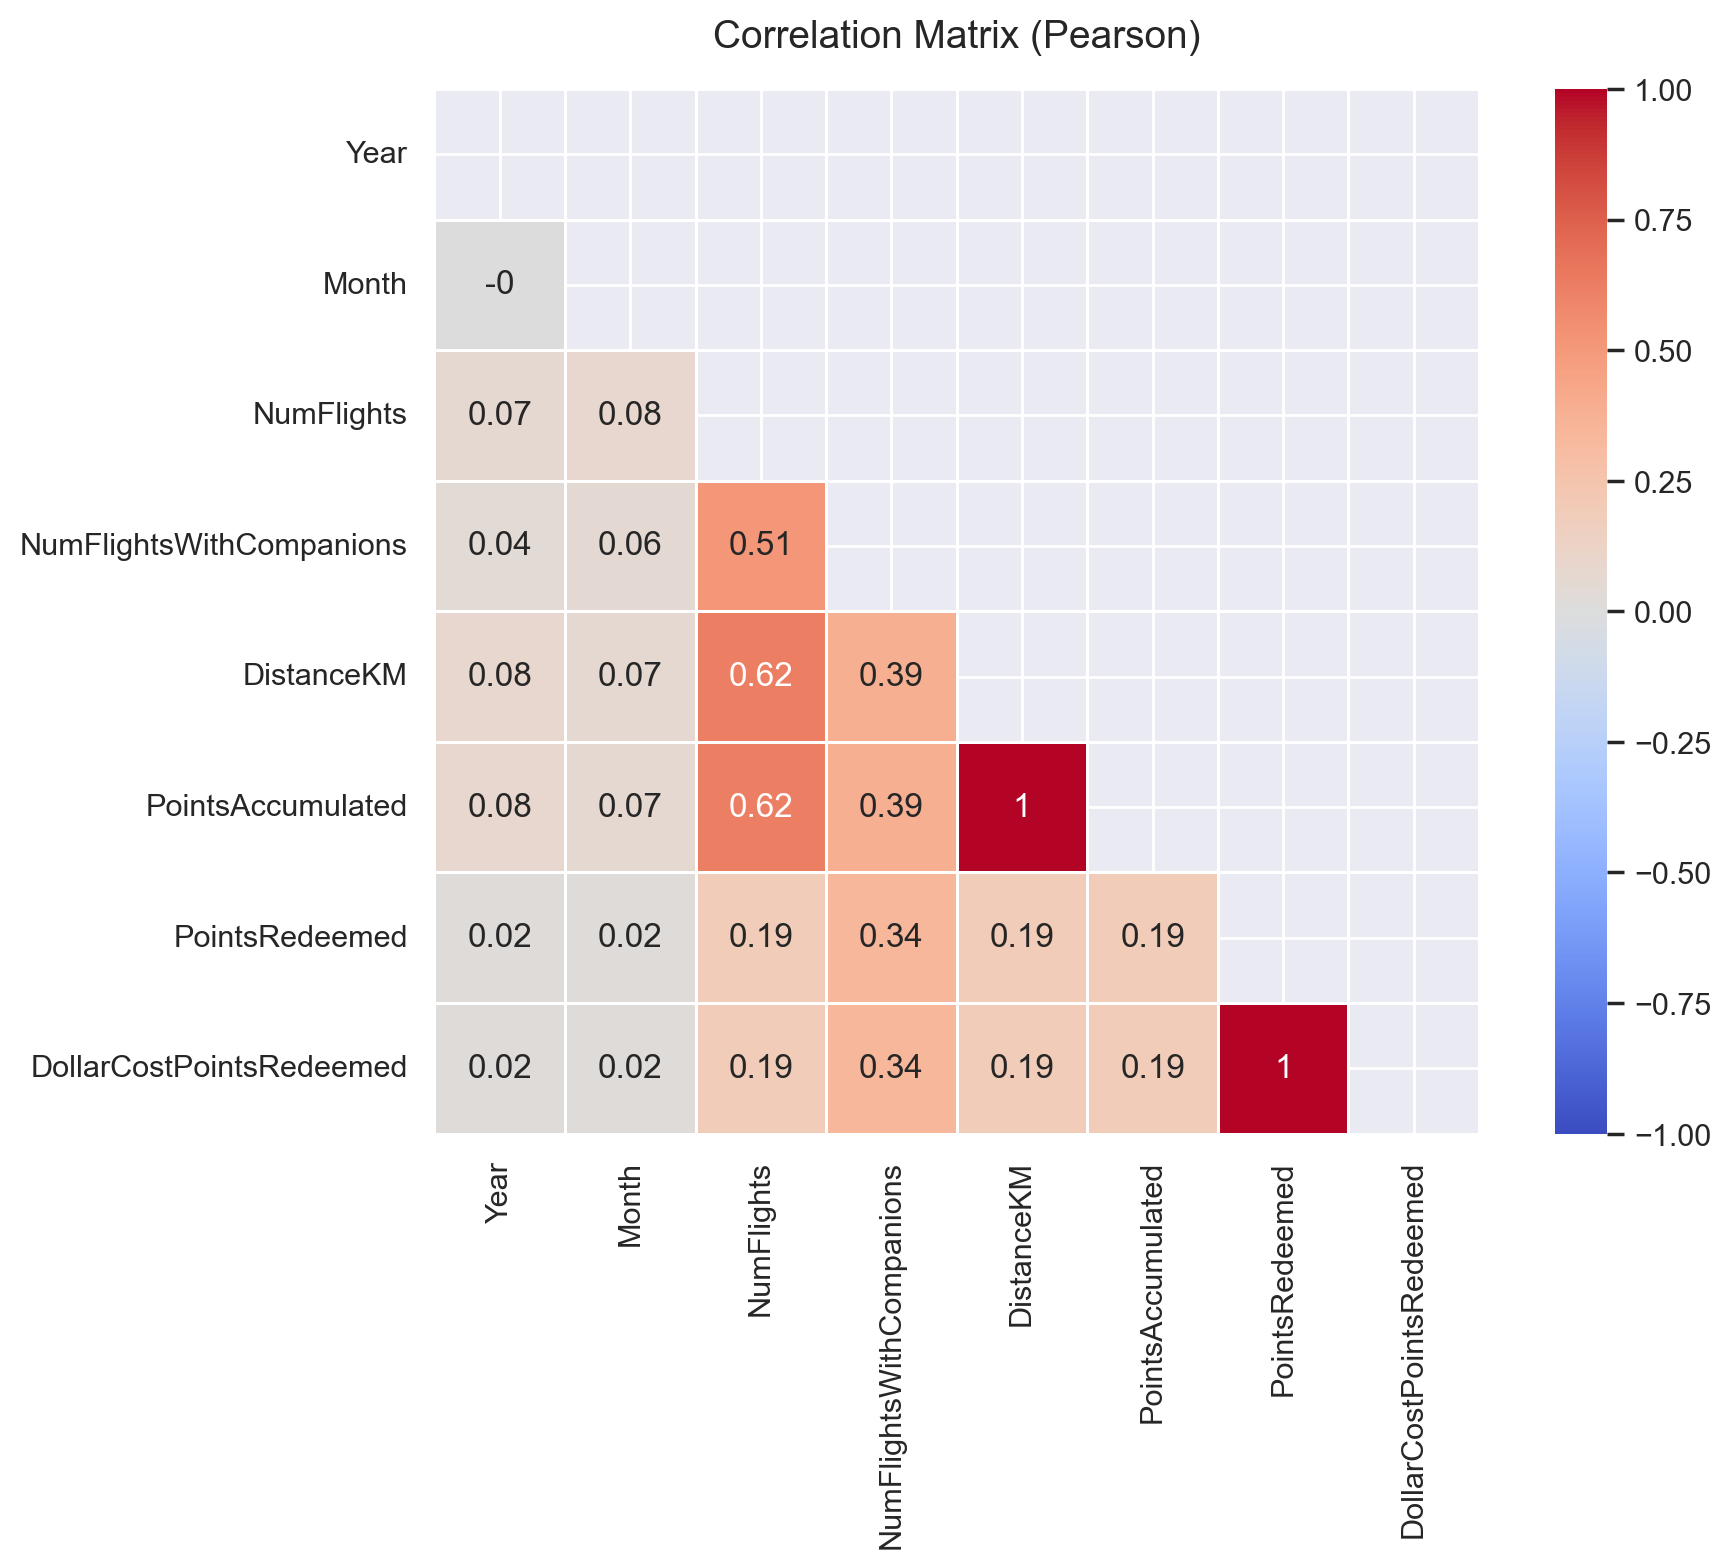

In [67]:
corr = new.corr(method="pearson"). round(2)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Visualize correlation matrix
fig = plt.figure(figsize=(10, 8))

sns.heatmap(
    corr,
    mask=mask,                # hide upper triangle
    annot=True,               # show values
    cmap="coolwarm",          # divergent color map
    center=0,                 # center colormap in 0
    linewidths=0.5,           # lines between cells to help visualization
    vmin=-1, vmax=1,          # fix scale
    square=True               # make cells square-shaped
)


plt.title("Correlation Matrix (Pearson)", fontsize=14, pad=15)
plt.tight_layout() # improve layout by reducing overlaps
plt.show()


Now the analysis of the correlation between each two variables it's much more easy. With this we understand that some variables are perfectly correlated, what let us think that maybe we should not consider all variables to go on with the work. 

PointsRedeemed and DollarCostPointsRedeemed, DistanceKm and Points Accumulated.

## General Look at the Data (CustomerDB)

In [68]:
customerDB.shape

(16921, 19)

In [69]:
customerDB.head(10)

,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
Loyalty#,,,,,,,,,,,,,,,,,,,
480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,female,Bachelor,Urban,70146.0,Married,Star,2/15/2019,NaN,3839.14,Standard
549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,male,College,Rural,0.0,Divorced,Star,3/9/2019,NaN,3839.61,Standard
429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,male,College,Urban,0.0,Single,Star,7/14/2017,1/8/2021,3839.75,Standard
608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,P1W 1K4,male,College,Suburban,0.0,Single,Star,2/17/2016,NaN,3839.75,Standard
530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,J8Y 3Z5,male,Bachelor,Suburban,97832.0,Married,Star,10/25/2017,NaN,3842.79,2021 Promotion
193662,Leatrice,Hanlin,Leatrice Hanlin,Canada,Yukon,Whitehorse,60.721188,-135.056840,Y2K 6R0,male,Bachelor,Rural,26262.0,Married,Star,5/7/2015,NaN,3844.57,Standard
927943,Hue,Sellner,Hue Sellner,Canada,Ontario,Toronto,43.653225,-79.383186,P5S 6R4,female,College,Urban,0.0,Single,Star,6/9/2017,NaN,3857.95,Standard
188893,Nakia,Cash,Nakia Cash,Canada,Ontario,Trenton,44.101128,-77.576309,K8V 4B2,male,Bachelor,Suburban,93272.0,Married,Star,12/8/2019,NaN,3861.49,Standard
852392,Arlene,Conterras,Arlene Conterras,Canada,Quebec,Montreal,45.501690,-73.567253,H2Y 2W2,female,Bachelor,Suburban,93272.0,Married,Star,5/30/2018,NaN,3861.49,Standard


In [70]:
customerDB.tail(20)

,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
Loyalty#,,,,,,,,,,,,,,,,,,,
999987,Layla,Murphy,Layla Murphy,Canada,New Brunswick,Fredericton,46.029263,-66.565150,R4H 2Y2,female,Bachelor,Urban,NaN,Single,Star,3/7/2017,3/7/2017,NaN,Standard
999988,Jana,Parker,Jana Parker,Canada,Quebec,Montreal,45.573672,-73.523012,N6B 1N3,male,College,Rural,NaN,Single,Star,8/22/2017,8/22/2017,NaN,Standard
999989,Ethan,Parker,Ethan Parker,Canada,Ontario,Trenton,44.075379,-77.550375,P8F 5C8,male,College,Rural,NaN,Married,Star,9/12/2015,9/12/2015,NaN,Standard
999990,Ryan,Anderson,Ryan Anderson,Canada,New Brunswick,Moncton,46.106617,-64.714267,B6P 6D0,female,College,Rural,NaN,Married,Star,6/10/2019,6/10/2019,NaN,Standard
999991,Olivia,Cote,Olivia Cote,Canada,New Brunswick,Fredericton,45.950000,-66.652437,X3W 5N2,female,College,Suburban,NaN,Married,Star,7/20/2019,7/20/2019,NaN,Standard
999992,Ella,Roy,Ella Roy,Canada,Ontario,Toronto,43.706878,-79.437412,P6D 6N2,male,College,Suburban,NaN,Single,Star,3/27/2021,3/27/2021,NaN,Standard
999993,Elijah,Cook,Elijah Cook,Canada,British Columbia,Dawson Creek,55.701475,-120.181716,W6H 0Z7,female,College,Suburban,NaN,Married,Star,1/27/2015,1/27/2015,NaN,Standard
999994,Ethan,Chan,Ethan Chan,Canada,Ontario,Ottawa,45.365906,-75.723181,B2F 3E1,female,College,Rural,NaN,Married,Star,5/5/2016,5/5/2016,NaN,Standard
999995,Liam,Wong,Liam Wong,Canada,Ontario,Ottawa,45.471557,-75.704868,B3A 2R0,female,College,Suburban,NaN,Married,Star,3/2/2020,3/2/2020,NaN,Standard


From the visualization of the head and tail of the data base we can already understand that some errors exist:

    - Missing values in some features
    - EnrollmentType as "2021 Promotion" when it's suppose to be a type
We will further analyse this using describe and info.

It's also possible to see that some variables are redundante, such as Costumer Name, First Name and Last Name
To solve this problem we will uniformize all the values in data preparation

In [71]:
customerDB.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16921 entries, 480934 to 100016
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   First Name               16921 non-null  object 
 1   Last Name                16921 non-null  object 
 2   Customer Name            16921 non-null  object 
 3   Country                  16921 non-null  object 
 4   Province or State        16921 non-null  object 
 5   City                     16921 non-null  object 
 6   Latitude                 16921 non-null  float64
 7   Longitude                16921 non-null  float64
 8   Postal code              16921 non-null  object 
 9   Gender                   16921 non-null  object 
 10  Education                16921 non-null  object 
 11  Location Code            16921 non-null  object 
 12  Income                   16901 non-null  float64
 13  Marital Status           16921 non-null  object 
 14  LoyaltyStatus        

From info we can see that:

    - missing values in Income, CustomerLifetimeValue, CancellationDate
* the missing values in the features Income can make sense in cases where customers do not want to share their personal annual income. Or they may also be input errors. (Depends on interpretation).

* We can also believe that it makes sense to have NaN values in “CancellationDate,” as this means that there are customers who have not left the program.

* For the “CustomerLifetimeValue” variable, we believe that it does not make sense to have NaN values because even if the customer has no value for the company, their CustomerLifetimeValue will be 0.

What will we do?

    Analyse with describe to have a different view

In [72]:
#To confirm that missing values exist
customerDB.replace("", np.nan, inplace=True)
customerDB.isna().sum()

First Name                     0
Last Name                      0
Customer Name                  0
Country                        0
Province or State              0
City                           0
Latitude                       0
Longitude                      0
Postal code                    0
Gender                         0
Education                      0
Location Code                  0
Income                        20
Marital Status                 0
LoyaltyStatus                  0
EnrollmentDateOpening          0
CancellationDate           14611
Customer Lifetime Value       20
EnrollmentType                 0
dtype: int64

In [73]:
customerDB.describe()

,Latitude,Longitude,Income,Customer Lifetime Value
count,16921.000000,16921.000000,16901.000000,16901.000000
mean,47.174500,-91.814768,37758.038400,7990.460188
std,3.307971,22.242429,30368.992499,6863.173093
min,42.984924,-135.056840,0.000000,1898.010000
25%,44.231171,-120.237660,0.000000,3979.720000
50%,46.087818,-79.383186,34161.000000,5780.180000
75%,49.282730,-74.596184,62396.000000,8945.690000
max,60.721188,-52.712578,99981.000000,83325.380000


From the numerical describe we can see that:

    - Once again we have the column Unnamed that has no relevant values

From the rest of the infromation we can't find any other problem from the first look

In [74]:
customerDB.describe(include='object')

,First Name,Last Name,Customer Name,Country,Province or State,City,Postal code,Gender,Education,Location Code,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,EnrollmentType
count,16921,16921,16921,16921,16921,16921,16921,16921,16921,16921,16921,16921,16921,2310,16921
unique,4941,15404,16921,1,11,29,75,2,5,3,3,3,2449,1260,2
top,Deon,Salberg,Cecilia Householder,Canada,Ontario,Toronto,V6E 3D9,female,Bachelor,Suburban,Married,Star,4/3/2015,7/7/2020,Standard
freq,13,4,1,16921,5468,3390,917,8497,10586,5716,9842,7761,34,8,15773


From the object describe we can conclude that:

    - there are no repeted Customer Names (count = unique = 16921);
    - there's only one Country, Canada
    - other things that will be analysed latter if they are relevant

## Data Exploration and Analysis (CustomerDB)

### Unique, Max, Min

In [75]:
print(customerDB["Country"].unique()) # with this we can see that only one country exists in the data base
print('-------------------------------------')
print(customerDB["Education"].unique())
print('-------------------------------------')
print(customerDB["Location Code"].unique())
print('-------------------------------------')
print(customerDB["Marital Status"].unique())
print('-------------------------------------')
print(customerDB["LoyaltyStatus"].unique())
print('-------------------------------------')
print(customerDB["EnrollmentType"].unique())

['Canada']
-------------------------------------
['Bachelor' 'College' 'Master' 'High School or Below' 'Doctor']
-------------------------------------
['Urban' 'Rural' 'Suburban']
-------------------------------------
['Married' 'Divorced' 'Single']
-------------------------------------
['Star' 'Aurora' 'Nova']
-------------------------------------
['Standard' '2021 Promotion']


From the results above we can see there aren't weird values for the features analysed. We can also verify that all Costumer's reside in Canada but in different areas, because there's diffrent Location Codes.

In [76]:
print(f"The minimum value of 'Income' is: {customerDB["Income"].min()}$")
print(f"The maximum value of 'Income' is: {customerDB["Income"].max()}$")

print(f"\nThe minimum value of 'Customer Lifetime Value' is: {customerDB["Customer Lifetime Value"].min()}$")
print(f"The maximum value of 'Customer Lifetime Value' is: {customerDB["Customer Lifetime Value"].max()}$")

The minimum value of 'Income' is: 0.0$
The maximum value of 'Income' is: 99981.0$

The minimum value of 'Customer Lifetime Value' is: 1898.01$
The maximum value of 'Customer Lifetime Value' is: 83325.38$


We can see that the income range of our customers is from 0$ to around 100k$ per year and that each customer will bring in at least 1 898$ in profit over their entire relationship with the company and at most 83 325.38$.

### Values Count

In [77]:
print(customerDB["Postal code"].value_counts()) 
#check the frequency of each postal code and we notice that some postal codes are much more common than others

print('-------------------------------------')
print(customerDB["Gender"].value_counts()) 
#we conclude that man and woman customers are almost equally represented in the data base

print('-------------------------------------')
print(customerDB["Education"].value_counts()) 
#we can see that most customers have a Bachelor degree and few have a Master's

print('-------------------------------------')
print(customerDB["Location Code"].value_counts()) 
#the location codes are quite equally distributed

print('-------------------------------------')
print(customerDB["Marital Status"].value_counts()) 
#most customers are married and only a few are divorced

print('-------------------------------------')
print(customerDB["LoyaltyStatus"].value_counts()) 
#there are way more Gold members and platinum members are the least common

print('-------------------------------------')
print(customerDB["EnrollmentType"].value_counts()) 
# most customers enrolled through a promotion and very few through 2021 promotion, the difference is huge


Postal code
V6E 3D9    917
V5R 1W3    699
V6T 1Y8    586
V6E 3Z3    538
M2M 7K8    538
          ... 
B6P 6D0      1
P8F 5C8      1
N6B 1N3      1
R4H 2Y2      1
M4A 1E4      1
Name: count, Length: 75, dtype: int64
-------------------------------------
Gender
female    8497
male      8424
Name: count, dtype: int64
-------------------------------------
Education
Bachelor                10586
College                  4283
High School or Below      792
Doctor                    742
Master                    518
Name: count, dtype: int64
-------------------------------------
Location Code
Suburban    5716
Rural       5668
Urban       5537
Name: count, dtype: int64
-------------------------------------
Marital Status
Married     9842
Single      4539
Divorced    2540
Name: count, dtype: int64
-------------------------------------
LoyaltyStatus
Star      7761
Nova      5722
Aurora    3438
Name: count, dtype: int64
-------------------------------------
EnrollmentType
Standard          15773
2

#### Check Duplicates

In [78]:
customerDB.duplicated().sum()

np.int64(0)

Checking the duplicates we verify that we don´t have any.

But it's still important to check the duplicates without the names features.

In [79]:
customerDB_no_name = customerDB.drop(columns=["First Name", "Last Name", "Customer Name"])
customerDB_no_name.duplicated().sum()

np.int64(0)

The result is the same so we can conclude that there aren't duplicated values in this DataFrame.

Contrary to what we have seen with the Flights dataset, here is not important to consider the values of Loyalty# as a feature. Still, so we can be consistint when analysing our datasets, we will had this column as a feature also to this dataset.

In [80]:
customerDB = pd.read_csv('DM_AIAI_CustomerDB.csv', sep = ",")
# code that we also did in the begining because there's a column with the index numbers that is completely unuseful
customerDB = customerDB.iloc[:, 1:] 

# to verify that the Loyalty# is now a feature and not an index anymore
customerDB.head()

,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,female,Bachelor,Urban,70146.0,Married,Star,2/15/2019,NaN,3839.14,Standard
1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,male,College,Rural,0.0,Divorced,Star,3/9/2019,NaN,3839.61,Standard
2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,male,College,Urban,0.0,Single,Star,7/14/2017,1/8/2021,3839.75,Standard
3,608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,P1W 1K4,male,College,Suburban,0.0,Single,Star,2/17/2016,NaN,3839.75,Standard
4,530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,J8Y 3Z5,male,Bachelor,Suburban,97832.0,Married,Star,10/25/2017,NaN,3842.79,2021 Promotion


### Correlation between variables

As before this correlation is also an important analysis to be done. However this doesn't make sense for all variables so we create a new DataFrame with only the variables we want to use to check the correlation.

In [81]:
# create a copy of the customerDB and select only the relevant columns for correlation analysis
new = customerDB.copy()
new = new[["Latitude", "Longitude", "Income", "Customer Lifetime Value", "EnrollmentDateOpening", "CancellationDate"]]

# converting date columns to datetime format
new['EnrollmentDateOpening'] = pd.to_datetime(new['EnrollmentDateOpening'], format='%m/%d/%Y', errors='coerce')
new['CancellationDate'] = pd.to_datetime(new['CancellationDate'], format='%m/%d/%Y', errors='coerce')

# using the two date columns converted before to create a new column with the customer duration in days
new['CustomerDurationDays'] = (new['CancellationDate'] - new['EnrollmentDateOpening']).dt.days

# choose the numerical columns for correlation analysis
cols = ["Latitude", "Longitude", "Income", "Customer Lifetime Value", "CustomerDurationDays"]
new[cols].corr(method='pearson')

,Latitude,Longitude,Income,Customer Lifetime Value,CustomerDurationDays
Latitude,1.000000,-0.764840,-0.002009,-0.002207,-0.015645
Longitude,-0.764840,1.000000,0.002928,0.006218,0.011865
Income,-0.002009,0.002928,1.000000,0.024026,-0.016729
Customer Lifetime Value,-0.002207,0.006218,0.024026,1.000000,-0.035992
CustomerDurationDays,-0.015645,0.011865,-0.016729,-0.035992,1.000000


From the code before it's difficult to get conclusions. We will visualize this matrix in a easy way of getting conclusions.

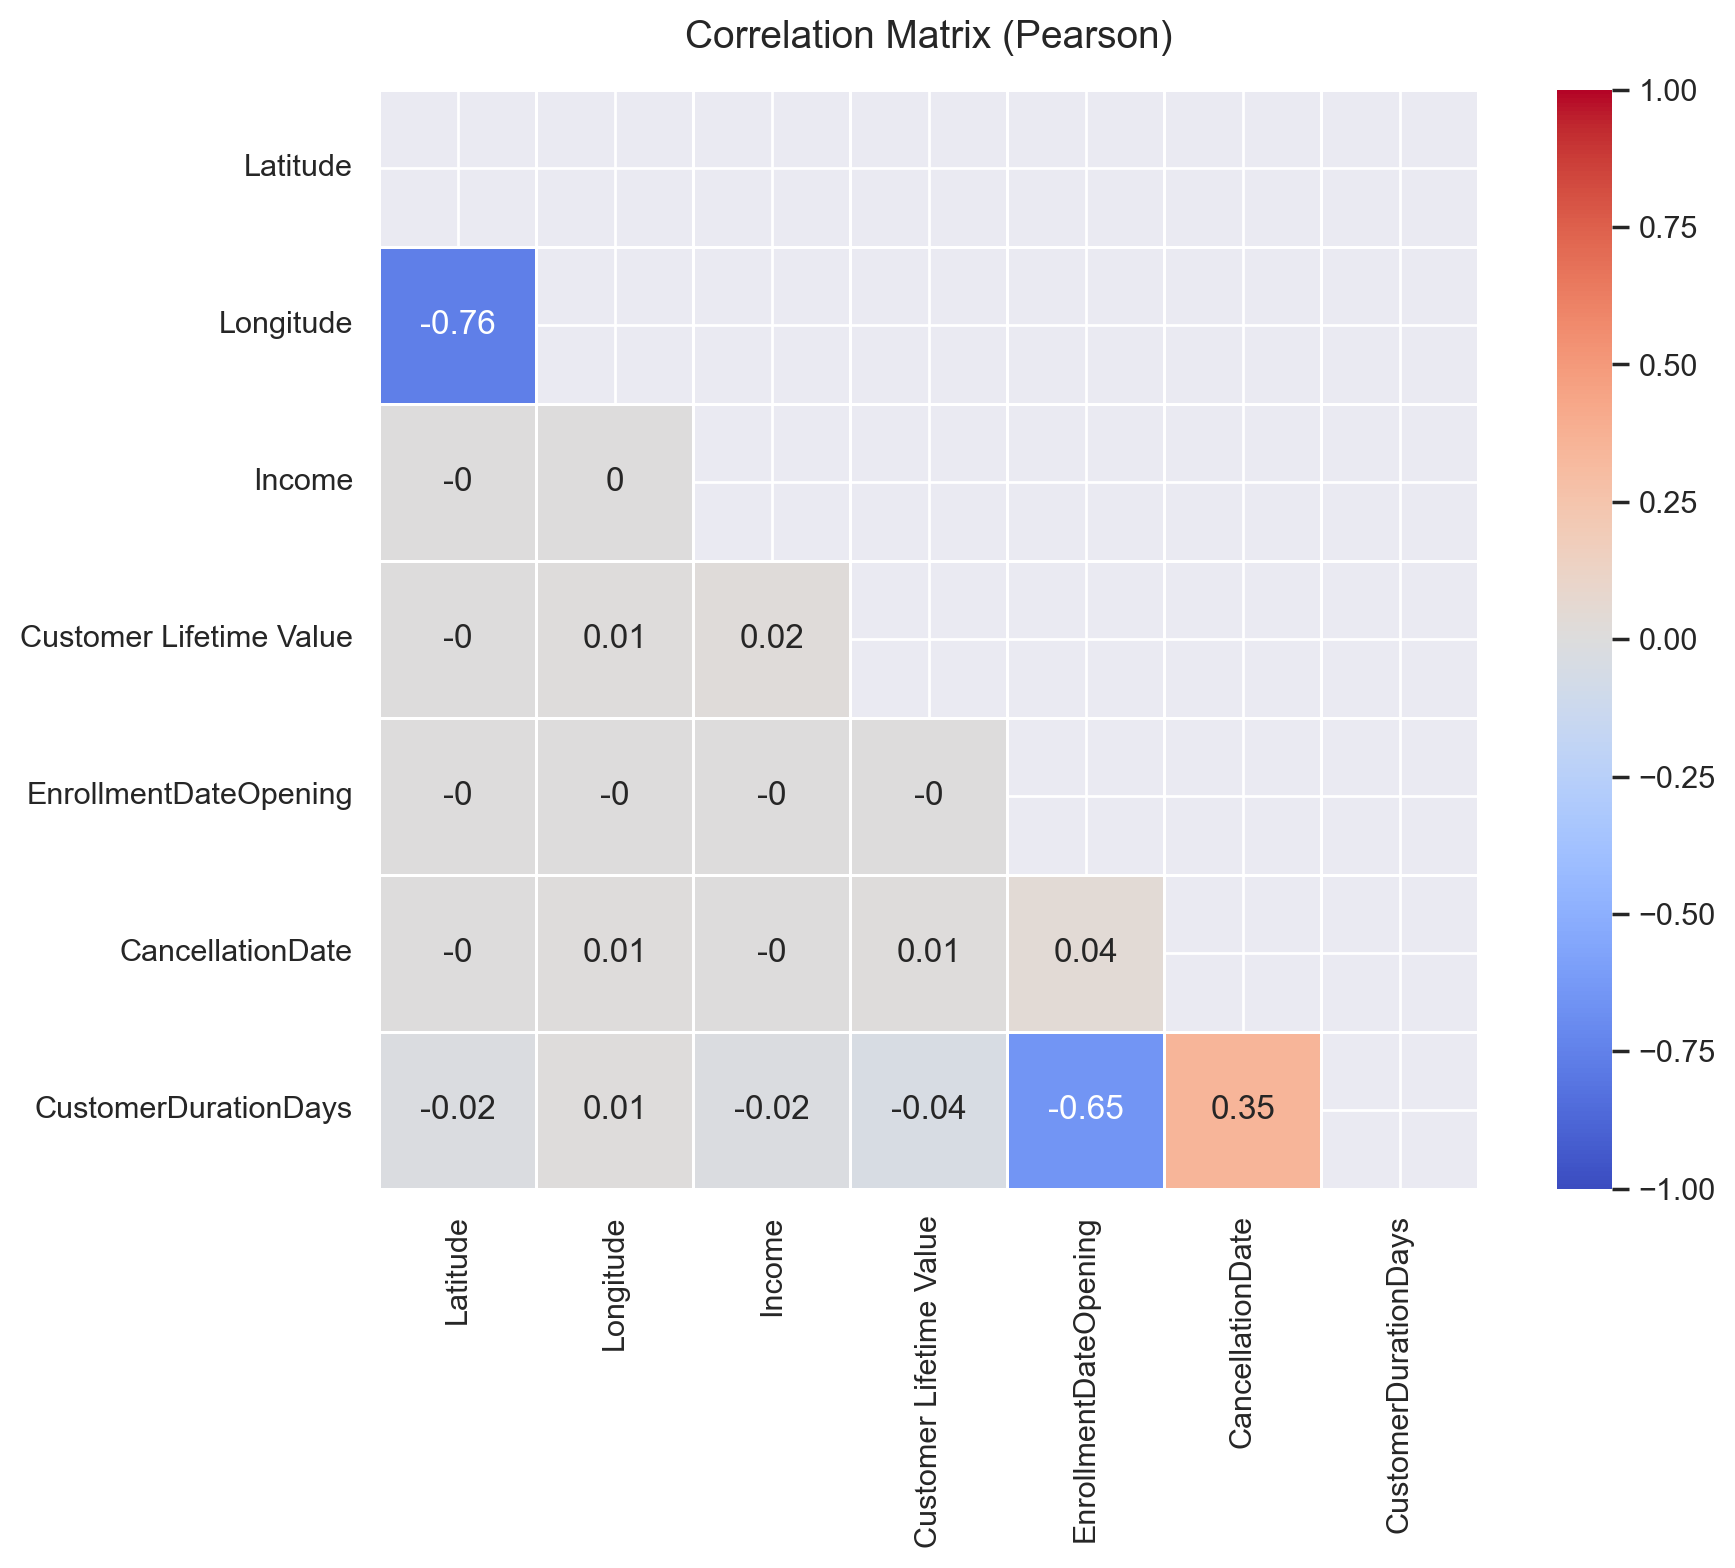

In [82]:
corr = new.corr(method="pearson"). round(2)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Visualize correlation matrix
fig = plt.figure(figsize=(10, 8))

sns.heatmap(
    corr,
    mask=mask,                # hide upper triangle
    annot=True,               # show values
    cmap="coolwarm",          # divergent color map
    center=0,                 # center colormap in 0
    linewidths=0.5,           # lines between cells to help visualization
    vmin=-1, vmax=1,          # fix scale
    square=True               # make cells square-shaped
)


plt.title("Correlation Matrix (Pearson)", fontsize=14, pad=15)
plt.tight_layout() # improve layout by reducing overlaps
plt.show()


Now the analysis of the correlation between each two variables it's much more easy. With this we understand that the variables EnrollmentDateOpening and CustomerDurationDays are correlated, but we don't think that this is a value that lead us to drop one of this variables. The same happen for the variables Latitude and Longitude that have a bigger correlation but maybe not enough to drop one of this variables.


## Data Quality Check in both Datasets

Identificar missing values